<a href="https://colab.research.google.com/github/dogukartal/IBM_AI_Labs/blob/main/Deep%20Learning%20with%20Keras%20and%20Tensorflow/Final%20Projects/Waste_Products_Classification_TransferLearning_and_FineTuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Importing Libraries
---

In [1]:
import numpy as np
import os
import glob
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import matplotlib.pyplot as plt
from matplotlib.image import imread

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Conv2D, MaxPooling2D,GlobalAveragePooling2D, Input
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionV3
from sklearn import metrics

import warnings
warnings.filterwarnings('ignore')

## Data
---

In [3]:
import requests
import zipfile
from tqdm import tqdm

url = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/kd6057VPpABQ2FqCbgu9YQ/o-vs-r-split-reduced-1200.zip"
file_name = "o-vs-r-split-reduced-1200.zip"

with requests.get(url, stream=True) as response:
    response.raise_for_status()
    with open(file_name, 'wb') as f:
        for chunk in response.iter_content(chunk_size=8192):
            f.write(chunk)


def extract_file_with_progress(file_name):
    with zipfile.ZipFile(file_name, 'r') as zip_ref:
        members = zip_ref.infolist()
        with tqdm(total=len(members), unit='file') as progress_bar:
            for member in members:
                zip_ref.extract(member)
                progress_bar.update(1)

extract_file_with_progress(file_name)
os.remove(file_name)

100%|██████████| 1207/1207 [00:00<00:00, 3357.26file/s]


In [4]:
img_rows, img_cols = 150, 150
batch_size = 32
n_epochs = 10
n_classes = 2
val_split = 0.2
verbosity = 1
path = 'o-vs-r-split/train/'
path_test = 'o-vs-r-split/test/'
input_shape = (img_rows, img_cols, 3)
labels = ['O', 'R'] # Organic waste, Recyclable waste

In [7]:
# Create ImageDataGenerators for training and validation and testing

# Train Generator
train_datagen = ImageDataGenerator(
    validation_split = val_split,
    rescale=1.0/255.0,
	  width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

train_generator = train_datagen.flow_from_directory(
    directory = path,
    batch_size = batch_size,
    class_mode='binary',
    shuffle = True,
    target_size=(img_rows, img_cols),
    subset = 'training'
)

# Validation Generator
val_datagen = ImageDataGenerator(
    validation_split = val_split,
    rescale=1.0/255.0,
)

val_generator = val_datagen.flow_from_directory(
    directory = path,
    batch_size = batch_size,
    class_mode='binary',
    shuffle = True,
    target_size=(img_rows, img_cols),
    subset = 'validation'
)

# Test Generator
test_datagen = ImageDataGenerator(
    rescale=1.0/255.0
)

test_generator = test_datagen.flow_from_directory(
    directory=path_test,
    class_mode='binary',
    batch_size=batch_size,
    shuffle=False,
    target_size=(img_rows, img_cols)
)

Found 800 images belonging to 2 classes.
Found 200 images belonging to 2 classes.
Found 200 images belonging to 2 classes.


Let's look at a few augmented images:


Labels: ['O', 'O', 'O', 'O', 'O']


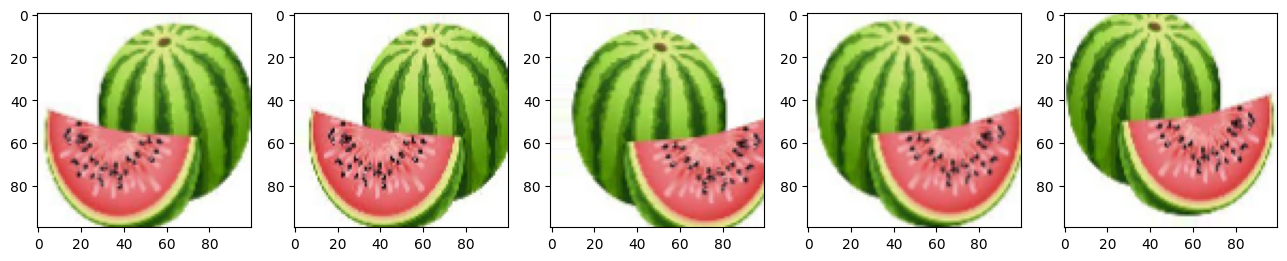

In [11]:
from pathlib import Path

IMG_DIM = (100, 100)

train_files = glob.glob('./o-vs-r-split/train/O/*')
train_files = train_files[:20]
train_imgs = [tf.keras.preprocessing.image.img_to_array(tf.keras.preprocessing.image.load_img(img, target_size=IMG_DIM)) for img in train_files]
train_imgs = np.array(train_imgs)
train_labels = [Path(fn).parent.name for fn in train_files]

img_id = 2
O_generator = train_datagen.flow(train_imgs[img_id:img_id+1], train_labels[img_id:img_id+1], batch_size=1)
O = [next(O_generator) for i in range(0,5)]
fig, ax = plt.subplots(1,5, figsize=(16, 6))
print('Labels:', [item[1][0] for item in O])
l = [ax[i].imshow(O[i][0][0]) for i in range(0,5)]

## Transfer Learning with VGG16
---

In [12]:
from tensorflow.keras.applications import vgg16

input_shape = (150, 150, 3)
vgg = vgg16.VGG16(include_top=False,
                        weights='imagenet',
                        input_shape=input_shape)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [13]:
# Flatten the output of VGG16
output = vgg.layers[-1].output
output = tf.keras.layers.Flatten()(output)
basemodel = Model(vgg.input, output)

In [14]:
# Freeze the layers
for layer in basemodel.layers:
    layer.trainable = False

In [17]:
input_shape = basemodel.output_shape[1]

model = Sequential()
model.add(basemodel)
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

model.summary()

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=1e-4),
              metrics=['accuracy'])

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ functional (Functional)              │ (None, 8192)                │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 512)                 │       4,194,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 1)                   │             513 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 19,172,673 (73.14 MB)

 Trainable params: 4,457,985 (17.01 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [18]:
from tensorflow.keras.callbacks import LearningRateScheduler

class LossHistory_(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.lr = []

    def on_epoch_end(self, epoch, logs={}):
        self.losses.append(logs.get('loss'))
        self.lr.append(exp_decay(epoch))
        print('lr:', exp_decay(len(self.losses)))

def exp_decay(epoch):
    initial_lrate = 1e-4
    k = 0.1
    lrate = initial_lrate * np.exp(-k * epoch)
    return lrate

checkpoint_path='O_R_tlearn_vgg16.keras'

loss_history = LossHistory_()
lrate = LearningRateScheduler(exp_decay)
early_stopping = EarlyStopping(monitor = 'val_loss', patience = 4, mode = 'min', min_delta=0.01)
model_cp = ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True, mode='min')

callbacks = [loss_history, lrate, early_stopping, model_cp]

In [19]:
extract_feat_model = model.fit(
    train_generator,
    steps_per_epoch = 5,
    epochs = 10,
    callbacks = callbacks,
    validation_data = val_generator,
    validation_steps = val_generator.samples // batch_size,
    verbose = 1
)

Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.5543 - loss: 0.6800lr: 9.048374180359596e-05
5/5 ━━━━━━━━━━━━━━━━━━━━ 108s 23s/step - accuracy: 0.5588 - loss: 0.6830 - val_accuracy: 0.6875 - val_loss: 0.5625 - learning_rate: 1.0000e-04
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.5491 - loss: 0.7112lr: 8.187307530779819e-05
5/5 ━━━━━━━━━━━━━━━━━━━━ 46s 9s/step - accuracy: 0.5596 - loss: 0.7009 - val_accuracy: 0.7500 - val_loss: 0.4793 - learning_rate: 9.0484e-05
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13s/step - accuracy: 0.7337 - loss: 0.5126 lr: 7.408182206817179e-05
5/5 ━━━━━━━━━━━━━━━━━━━━ 133s 31s/step - accuracy: 0.7385 - loss: 0.5097 - val_accuracy: 0.6302 - val_loss: 0.6194 - learning_rate: 8.1873e-05
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.7491 - loss: 0.4886 lr: 6.703200460356394e-05
5/5 ━━━━━━━━━━━━━━━━━━━━ 53s 10s/step - accuracy: 0.7523 - loss: 0.4856 - val_accuracy: 0.8750 - val_loss: 0.4045 - learning_rate: 7.4082e-05
Epo

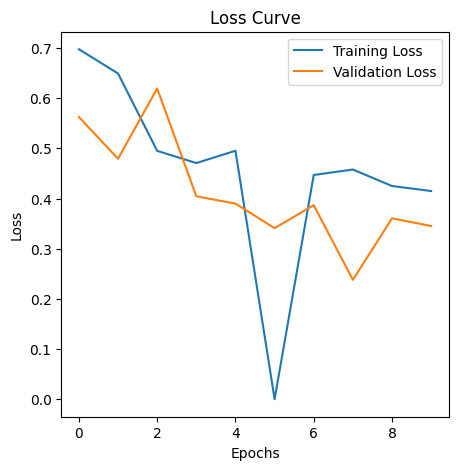

In [20]:
history = extract_feat_model

# Losss Curves
plt.figure(figsize=(5, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

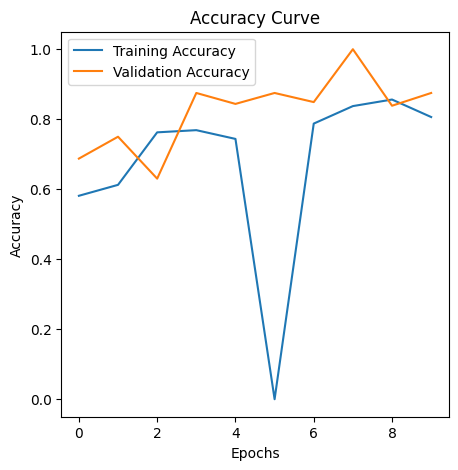

In [21]:
# Accuracy Curves
plt.figure(figsize=(5, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Fine-Tuning the Model
---

In [22]:
from tensorflow.keras.applications import vgg16

input_shape = (150, 150, 3)

vgg = vgg16.VGG16(
    include_top=False,
    weights='imagenet',
    input_shape=input_shape
)

# Flatten the output
output = vgg.layers[-1].output
output = tf.keras.layers.Flatten()(output)
basemodel = Model(vgg.input, output)

# Freeze the layers
for layer in basemodel.layers:
    layer.trainable = False

display([layer.name for layer in basemodel.layers])

set_trainable = False
for layer in basemodel.layers:
    if layer.name in ['block5_conv3']:
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

for layer in basemodel.layers:
    print(f"{layer.name}: {layer.trainable}")

['input_layer_4',
 'block1_conv1',
 'block1_conv2',
 'block1_pool',
 'block2_conv1',
 'block2_conv2',
 'block2_pool',
 'block3_conv1',
 'block3_conv2',
 'block3_conv3',
 'block3_pool',
 'block4_conv1',
 'block4_conv2',
 'block4_conv3',
 'block4_pool',
 'block5_conv1',
 'block5_conv2',
 'block5_conv3',
 'block5_pool',
 'flatten_1']

input_layer_4: False
block1_conv1: False
block1_conv2: False
block1_pool: False
block2_conv1: False
block2_conv2: False
block2_pool: False
block3_conv1: False
block3_conv2: False
block3_conv3: False
block3_pool: False
block4_conv1: False
block4_conv2: False
block4_conv3: False
block4_pool: False
block5_conv1: False
block5_conv2: False
block5_conv3: True
block5_pool: True
flatten_1: True


In [23]:
model = Sequential()
model.add(basemodel)
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

checkpoint_path='O_R_tlearn_fine_tune_vgg16.keras'

# learning schedule callback
loss_history_ = LossHistory_()
lrate_ = LearningRateScheduler(exp_decay)

keras_callbacks = [
      EarlyStopping(monitor = 'val_loss',
                    patience = 4,
                    mode = 'min',
                    min_delta=0.01),
      ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True, mode='min')
]

callbacks_list_ = [loss_history_, lrate_] + keras_callbacks

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=1e-4),
              metrics=['accuracy'])

fine_tune_model = model.fit(
    train_generator,
    steps_per_epoch=5,
    epochs=10,
    callbacks = callbacks_list_,
    validation_data=val_generator,
    validation_steps=val_generator.samples // batch_size,
    verbose=1
)

Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.6321 - loss: 0.6916lr: 9.048374180359596e-05
5/5 ━━━━━━━━━━━━━━━━━━━━ 101s 22s/step - accuracy: 0.6299 - loss: 0.6882 - val_accuracy: 0.6979 - val_loss: 0.5570 - learning_rate: 1.0000e-04
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.7740 - loss: 0.4918lr: 8.187307530779819e-05
5/5 ━━━━━━━━━━━━━━━━━━━━ 50s 10s/step - accuracy: 0.7752 - loss: 0.4904 - val_accuracy: 0.7500 - val_loss: 0.5017 - learning_rate: 9.0484e-05
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.7843 - loss: 0.4119lr: 7.408182206817179e-05
5/5 ━━━━━━━━━━━━━━━━━━━━ 102s 24s/step - accuracy: 0.7806 - loss: 0.4160 - val_accuracy: 0.8333 - val_loss: 0.4063 - learning_rate: 8.1873e-05
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.8242 - loss: 0.4015lr: 6.703200460356394e-05
5/5 ━━━━━━━━━━━━━━━━━━━━ 46s 10s/step - accuracy: 0.8233 - loss: 0.4017 - val_accuracy: 0.7500 - val_loss: 0.5595 - learning_rate: 7.4082e-05
Epoch

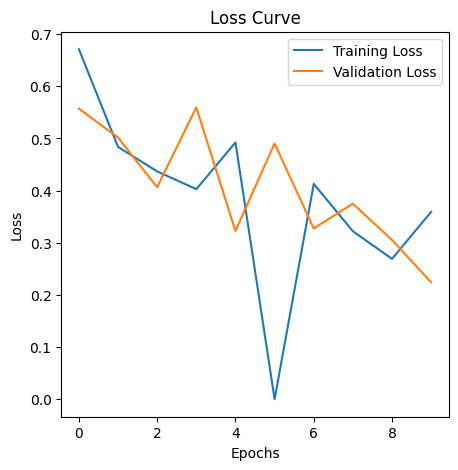

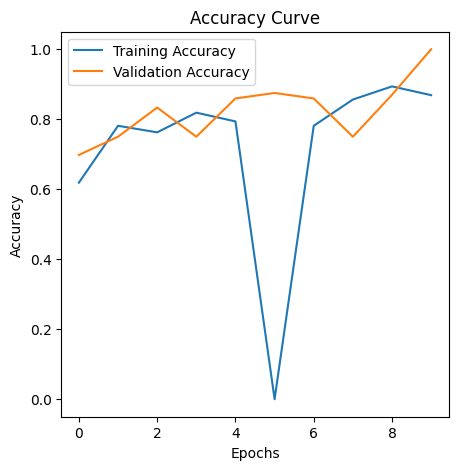

In [24]:
history = fine_tune_model

plt.figure(figsize=(5, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(5, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Evaluate Models
---

In [25]:
from pathlib import Path

# Load saved models
extract_feat_model = tf.keras.models.load_model('O_R_tlearn_vgg16.keras')
fine_tune_model = tf.keras.models.load_model('O_R_tlearn_fine_tune_vgg16.keras')

IMG_DIM = (150, 150)

# Load test images
test_files_O = glob.glob('./o-vs-r-split/test/O/*')
test_files_R = glob.glob('./o-vs-r-split/test/R/*')
test_files = test_files_O[:50] + test_files_R[:50]

test_imgs = [tf.keras.preprocessing.image.img_to_array(tf.keras.preprocessing.image.load_img(img, target_size=IMG_DIM)) for img in test_files]
test_imgs = np.array(test_imgs)
test_labels = [Path(fn).parent.name for fn in test_files]

# Standardize
test_imgs_scaled = test_imgs.astype('float32')
test_imgs_scaled /= 255

class2num_lt = lambda l: [0 if x == 'O' else 1 for x in l]
num2class_lt = lambda l: ['O' if x < 0.5 else 'R' for x in l]

test_labels_enc = class2num_lt(test_labels)

# Make predictions for both models
predictions_extract_feat_model = extract_feat_model.predict(test_imgs_scaled, verbose=0)
predictions_fine_tune_model = fine_tune_model.predict(test_imgs_scaled, verbose=0)

# Convert predictions to class labels
predictions_extract_feat_model = num2class_lt(predictions_extract_feat_model)
predictions_fine_tune_model = num2class_lt(predictions_fine_tune_model)

# Print classification report for both models
print('Extract Features Model')
print(metrics.classification_report(test_labels, predictions_extract_feat_model))
print('Fine-Tuned Model')
print(metrics.classification_report(test_labels, predictions_fine_tune_model))

Extract Features Model
              precision    recall  f1-score   support

           O       0.82      0.84      0.83        50
           R       0.84      0.82      0.83        50

    accuracy                           0.83       100
   macro avg       0.83      0.83      0.83       100
weighted avg       0.83      0.83      0.83       100

Fine-Tuned Model
              precision    recall  f1-score   support

           O       0.80      0.88      0.84        50
           R       0.87      0.78      0.82        50

    accuracy                           0.83       100
   macro avg       0.83      0.83      0.83       100
weighted avg       0.83      0.83      0.83       100



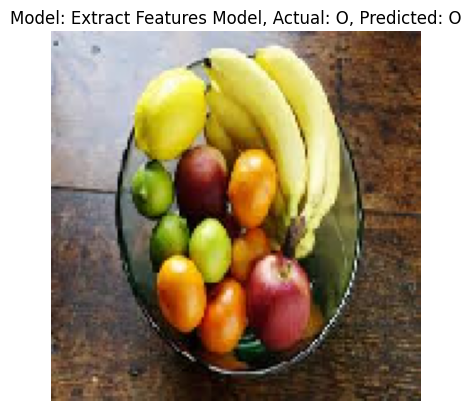

In [26]:
# Plot one of the images with actual label and predicted label as title
def plot_image_with_title(image, model_name, actual_label, predicted_label):
    plt.imshow(image)
    plt.title(f"Model: {model_name}, Actual: {actual_label}, Predicted: {predicted_label}")
    plt.axis('off')
    plt.show()

# Specify index of image to plot, for example index 0
index_to_plot = 0
plot_image_with_title(
    image=test_imgs[index_to_plot].astype('uint8'),
    model_name='Extract Features Model',
    actual_label=test_labels[index_to_plot],
    predicted_label=predictions_extract_feat_model[index_to_plot],
)

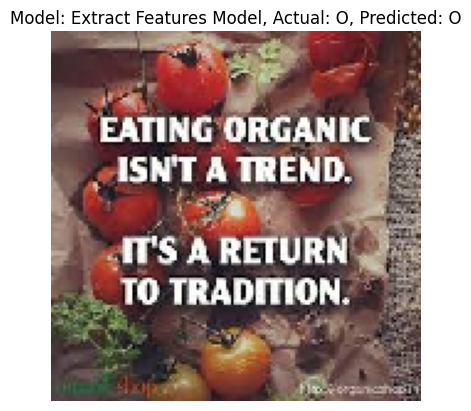

In [27]:
index_to_plot = 1
plot_image_with_title(
    image=test_imgs[index_to_plot].astype('uint8'),
    model_name='Extract Features Model',
    actual_label=test_labels[index_to_plot],
    predicted_label=predictions_extract_feat_model[index_to_plot],
)

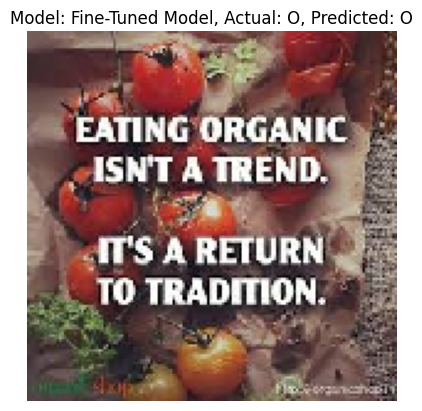

In [28]:
index_to_plot = 1
plot_image_with_title(
    image=test_imgs[index_to_plot].astype('uint8'),
    model_name='Fine-Tuned Model',
    actual_label=test_labels[index_to_plot],
    predicted_label=predictions_fine_tune_model[index_to_plot],
)